# Multi-modal RAG with easyparser PDF and Langchain

Many documents contain a mixture of content types, including text, tables and images.

Yet, information captured in images is lost in most RAG applications.

In this notebook, we aim to demonstrate how easyparser PDF parser can be used to maintain multimodal information from original files and integrate with Langchain in a downstream RAG application.

![](https://i.imgur.com/5BpuocV.png)


---

* Use a multimodal LLM (such as [GPT-4o](https://openai.com/index/hello-gpt-4o/), [LLaVA](https://llava.hliu.cc/), or [FUYU-8b](https://www.adept.ai/blog/fuyu-8b)) to produce text summaries from images and tables
* Embed and retrieve image, table and text summaries with a reference to the raw images and tables
* Pass raw images, tables and text chunks to a multimodal LLM for answer synthesis   

---



* We will use **easyparser PDF parser** to parse images, text, and tables from documents (PDFs).
* We will use the [multi-vector retriever](https://python.langchain.com/docs/modules/data_connection/retrievers/multi_vector) with [Chroma](https://www.trychroma.com/) and InMemoryStore to store raw text and images along with their summaries for retrieval.
* We will use GPT-4o for both image summarization (for retrieval) as well as final answer synthesis from join review of images and texts (or tables).


___Adapted from: [notebook](https://colab.research.google.com/drive/1QzQYQxH052Rs088rxMQDveRjoVdkdl74)___



In [ ]:
!pip install langchain
!pip install langchain-openai
!pip install langchain-chroma
!pip install langchain-community
!pip install langchain-experimental
!pip install "git+https://github.com/easyparser/easyparser.git@main#egg=easyparser[pdf,ocr]"

## Data Loading

### Partition PDF tables, text, and images
  

In [ ]:
!wget https://sgp.fas.org/crs/misc/IF10244.pdf

In [2]:
from easyparser import parse

doc = './IF10244.pdf'

root_chunk = parse(doc)
root_chunk.print_graph()

2025-05-28 17:26:20,073 - DownloadModel - INFO: /Users/taprosoft/Shared/debug/chunking/cookbook/env/lib/python3.12/site-packages/rapid_layout/models/yolov8n_layout_general6.onnx already exists
2025-05-28 17:26:20,100 - rapid_layout - INFO: yolov8n_layout_general6 contains ['Text', 'Title', 'Figure', 'Table', 'Caption', 'Equation']


 Chunk(id=8eb0a, ctype=root, origin=IF10244.pdf)
     Chunk(id=0e404, ctype=figure, mimetype=image/png)
     Chunk(id=55466, ctype=figure, mimetype=image/png)
     Chunk(id=ed633, ctype=figure, mimetype=image/png)
     Chunk(id=098cd, ctype=table, mimetype=image/png)
     Chunk(id=fa94f, ctype=para, content=https://crsreports.congress.gov)
     Chunk(id=2c3f3, ctype=para, content=Updated June 1, 2023)
     Chunk(id=20879, ctype=header, content=Wildfire Statistics)
     Chunk(id=d6c38, ctype=para, content=Wildfires are unplanned fires, including lightning... (105 more words))
     Chunk(id=0095b, ctype=para, content=Wildfire statistics help illustrate past U.S. wild... (94 more words))
     Chunk(id=b4c47, ctype=header, content=Table 1. Annual Wildfires and Acres Burned)
     Chunk(id=63d94, ctype=table, mimetype=image/png)
     Chunk(id=108cc, ctype=para, content=Source: National Interagency Coordination Center (NICC))
     Chunk(id=2f923, ctype=para, content=Wildland Fire Summary and 

Found 31 paragraphs
Found 3 tables
Found 5 figures
Doc 0: https://crsreports.congress.gov...
Doc 1: Updated June 1, 2023...
Doc 2: Wildfires are unplanned fires, including lightning-caused  fires, unauthorized human-caused fires, a...
Doc 3: Wildfire statistics help illustrate past U.S. wildfire activity.  Nationwide data compiled by the Na...
Doc 4: Source: National Interagency Coordination Center (NICC)...
Table 0:
```table
                  2018     2019     2020     2021     2022

 Number   of  Fires  (thousands)

 Federal          12.5      10.9     14.4     14.0     11.7

     FS            5.6      5.3      6.7       6.2     5.9

     DOI           7.0      5.3      7.6       7.6     5.8

     Other         0.1      0.2      <0.1      0.2     0.1

 Nonfederal       45.6      39.6     44.6     45.0     57.2

 Total            58.1     50.5      59.0     59.0    69.0

 Acres  Burned  (millions)

 Federal           4.6      3.1      7.1       5.2     4.0

     FS            2.3    

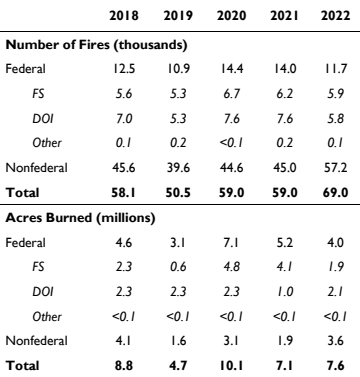

Table 1:
```table
                      2019       2020      2021       2022

 Structures  Burned    963      17,904     5,972      2,717

 %  Residences         46%       54%        60%        46%
```


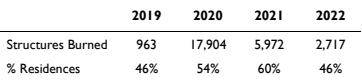

Figure 0:



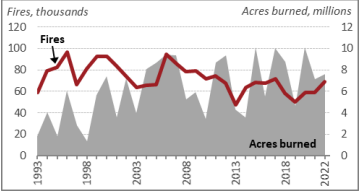

Figure 1:



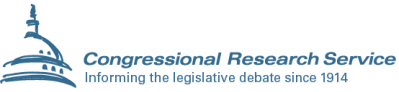

In [3]:
docs = root_chunk.find_all(ctype="para")
tables = root_chunk.find_all(ctype="table")
figures = root_chunk.find_all(ctype="figure")

print(f"Found {len(docs)} paragraphs")
print(f"Found {len(tables)} tables")
print(f"Found {len(figures)} figures")

for i, doc in enumerate(docs[:5]):  # Display first 5 paragraphs
    print(f"Doc {i}: {doc.content[:100]}...")
    
for i, table in enumerate(tables[1:3]):  # Display first 2 tables
    print(f"Table {i}:\n{table.text}")
    display(table.render("multi")[0]["content"])
    
for i, figure in enumerate(figures[:2]):  # Display first 2 figures
    print(f"Figure {i}:\n{figure.text}")
    display(figure.render("multi")[0]["content"])
    

In [ ]:
# write figures to disk
import os
output_figure_dir = "./figures"
os.mkdir(output_figure_dir)

for idx, figure in enumerate(figures):
    with open(f"{output_figure_dir}/figure_{idx}.png", "wb") as f:
        f.write(figure.content)

In [4]:
!ls -l ./figures

total 328
-rw-r--r--@ 1 taprosoft  staff  40954 May 28 17:21 figure_0.png
-rw-r--r--@ 1 taprosoft  staff  21448 May 28 17:21 figure_1.png
-rw-r--r--@ 1 taprosoft  staff  30368 May 28 17:21 figure_2.png
-rw-r--r--@ 1 taprosoft  staff  35529 May 28 17:21 figure_3.png
-rw-r--r--@ 1 taprosoft  staff  31173 May 28 17:21 figure_4.png


#### Enter Open AI API Key

In [5]:
from getpass import getpass

OPENAI_KEY = getpass('Enter Open AI API Key: ')

In [6]:
import os

os.environ['OPENAI_API_KEY'] = OPENAI_KEY

#### Load Connection to LLM

Here we create a connection to ChatGPT to use later in our chains

In [7]:
from langchain_openai import ChatOpenAI

chatgpt = ChatOpenAI(model_name='gpt-4o', temperature=0)

## Multi-vector retriever

Use [multi-vector-retriever](https://python.langchain.com/docs/modules/data_connection/retrievers/multi_vector#summary) to index image (and / or text, table) summaries, but retrieve raw images (along with raw texts or tables).

### Text and Table summaries

We will use GPT-4o to produce table and, text summaries.

Text summaries are advised if using large chunk sizes (e.g., as set above, we use 4k token chunks).

Summaries are used to retrieve raw tables and / or raw chunks of text.

In [ ]:
# Convert paragraphs and tables to LangChain documents
docs = [doc.to_langchain_node() for doc in docs]
tables = [table.to_langchain_node() for table in tables]

print(docs[1].page_content)
print(tables[1].page_content)

Updated June 1, 2023
```table
                  2018     2019     2020     2021     2022

 Number   of  Fires  (thousands)

 Federal          12.5      10.9     14.4     14.0     11.7

     FS            5.6      5.3      6.7       6.2     5.9

     DOI           7.0      5.3      7.6       7.6     5.8

     Other         0.1      0.2      <0.1      0.2     0.1

 Nonfederal       45.6      39.6     44.6     45.0     57.2

 Total            58.1     50.5      59.0     59.0    69.0

 Acres  Burned  (millions)

 Federal           4.6      3.1      7.1       5.2     4.0

     FS            2.3      0.6      4.8       4.1     1.9

     DOI           2.3      2.3      2.3       1.0     2.1

     Other        <0.1      <0.1     <0.1     <0.1     <0.1

 Nonfederal        4.1      1.6      3.1       1.9     3.6

 Total             8.8      4.7      10.1     7.1      7.6
```


In [12]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_core.runnables import RunnablePassthrough

# Prompt
prompt_text = """
You are an assistant tasked with summarizing tables and text particularly for semantic retrieval.
These summaries will be embedded and used to retrieve the raw text or table elements
Give a detailed summary of the table or text below that is well optimized for retrieval.
For any tables also add in a one line description of what the table is about besides the summary.
Do not add additional words like Summary: etc.

Table or text chunk:
{element}
"""
prompt = ChatPromptTemplate.from_template(prompt_text)

# Summary chain
summarize_chain = (
                    {"element": RunnablePassthrough()}
                      |
                    prompt
                      |
                    chatgpt
                      |
                    StrOutputParser() # extracts the response as text and returns it as a string
)

# Initialize empty summaries
text_summaries = []
table_summaries = []

text_docs = [doc.page_content for doc in docs]
table_docs = [table.page_content for table in tables]

text_summaries = summarize_chain.batch(text_docs, {"max_concurrency": 5})
table_summaries = summarize_chain.batch(table_docs, {"max_concurrency": 5})

len(text_summaries), len(table_summaries)

(31, 3)

In [15]:
text_summaries[1]

'The text indicates that the information was last updated on June 1, 2023.'

In [16]:
table_summaries[1]

'The table provides data on the number of fires and acres burned in the United States from 2018 to 2022, categorized by federal and nonfederal sources. The number of fires is measured in thousands, while acres burned is measured in millions. \n\nFor the number of fires, federal sources include the Forest Service (FS), the Department of the Interior (DOI), and other federal entities. In 2022, the total number of fires was 69,000, with 11,700 from federal sources and 57,200 from nonfederal sources. The highest number of federal fires occurred in 2020, totaling 14,400, while nonfederal fires peaked in 2022 at 57,200.\n\nFor acres burned, federal sources again include FS, DOI, and other federal entities. In 2022, a total of 7.6 million acres were burned, with 4.0 million acres from federal sources and 3.6 million from nonfederal sources. The year 2020 saw the highest total acres burned at 10.1 million, with federal sources contributing 7.1 million acres. The data indicates fluctuations in 

### Image summaries

We will use [GPT-4o](https://openai.com/index/hello-gpt-4o/) to produce the image summaries.

* We pass base64 encoded images

In [22]:
import base64
import os

from langchain_core.messages import HumanMessage


def encode_image(image_path):
    """Getting the base64 string"""
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")


def image_summarize(img_base64, prompt):
    """Make image summary"""
    chat = ChatOpenAI(model="gpt-4o", temperature=0)

    msg = chat.invoke(
        [
            HumanMessage(
                content=[
                    {"type": "text", "text": prompt},
                    {
                        "type": "image_url",
                        "image_url": {"url": f"data:image/png;base64,{img_base64}"},
                    },
                ]
            )
        ]
    )
    return msg.content


def generate_img_summaries(path):
    """
    Generate summaries and base64 encoded strings for images
    path: Path to list of .jpg files extracted by Unstructured
    """

    # Store base64 encoded images
    img_base64_list = []

    # Store image summaries
    image_summaries = []

    # Prompt
    prompt = """You are an assistant tasked with summarizing images for retrieval.
                Remember these images could potentially contain graphs, charts or tables also.
                These summaries will be embedded and used to retrieve the raw image for question answering.
                Give a detailed summary of the image that is well optimized for retrieval.
                Do not add additional words like Summary: etc.
             """

    # Apply to images
    for img_file in sorted(os.listdir(path)):
        if img_file.endswith(".png"):
            img_path = os.path.join(path, img_file)
            base64_image = encode_image(img_path)
            img_base64_list.append(base64_image)
            image_summaries.append(image_summarize(base64_image, prompt))

    return img_base64_list, image_summaries


# Image summaries
IMG_PATH = './figures'
imgs_base64, image_summaries = generate_img_summaries(IMG_PATH)

In [23]:
len(imgs_base64), len(image_summaries)

(5, 5)

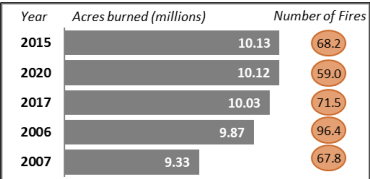

In [26]:
from IPython.display import display, Image
display(Image('./figures/figure_2.png'))

In [44]:
image_summaries[2]

'Bar chart displaying data on acres burned and number of fires for selected years. The years listed are 2015, 2020, 2017, 2006, and 2007. Acres burned in millions are shown as horizontal bars: 2015 (10.13), 2020 (10.12), 2017 (10.03), 2006 (9.87), and 2007 (9.33). The number of fires is displayed in orange circles: 2015 (68.2), 2020 (59.0), 2017 (71.5), 2006 (96.4), and 2007 (67.8). The chart highlights variations in fire occurrences and the extent of land affected over the years.'

### Add to vectorstore

Add raw docs and doc summaries to [Multi Vector Retriever](https://python.langchain.com/docs/modules/data_connection/retrievers/multi_vector#summary):

* Store the raw texts, tables, and images in the `docstore` (here we are using InMemoryStore).
* Store the texts, table summaries, and image summaries in the `vectorstore` (here we are using Chroma) for efficient semantic retrieval.

### Open AI Embedding Models

LangChain enables us to access Open AI embedding models which include the newest models: a smaller and highly efficient `text-embedding-3-small` model, and a larger and more powerful `text-embedding-3-large` model.

In [28]:
from langchain_openai import OpenAIEmbeddings

# details here: https://openai.com/blog/new-embedding-models-and-api-updates
openai_embed_model = OpenAIEmbeddings(model='text-embedding-3-small')

In [61]:
import uuid

from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain_core.stores import InMemoryStore
from langchain_chroma import Chroma
from langchain_core.documents import Document


def create_multi_vector_retriever(
    docstore, vectorstore, text_summaries, texts, table_summaries, tables, image_summaries, images
):
    """
    Create retriever that indexes summaries, but returns raw images or texts
    """


    id_key = "doc_id"

    # Create the multi-vector retriever
    retriever = MultiVectorRetriever(
        vectorstore=vectorstore,
        docstore=docstore,
        id_key=id_key,
    )

    # Helper function to add documents to the vectorstore and docstore
    def add_documents(retriever, doc_summaries, doc_contents):
        doc_ids = [str(uuid.uuid4()) for _ in doc_contents]
        for summary in doc_summaries:
            print(f"Adding summary: {summary[:50]}...")
        summary_docs = [
            Document(page_content=s, metadata={id_key: doc_ids[i]})
            for i, s in enumerate(doc_summaries)
        ]
        retriever.vectorstore.add_documents(summary_docs)
        retriever.docstore.mset(list(zip(doc_ids, doc_contents)))

    # Add texts, tables, and images
    # Check that text_summaries is not empty before adding
    # if text_summaries:
    #     print("Adding text summaries to retriever")
    #     add_documents(retriever, text_summaries, texts)
    # Check that table_summaries is not empty before adding
    if table_summaries:
        print("Adding table summaries to retriever")
        add_documents(retriever, table_summaries, tables)
    # Check that image_summaries is not empty before adding
    if image_summaries:
        print("Adding image summaries to retriever")
        add_documents(retriever, image_summaries, images)

    return retriever


# The vectorstore to use to index the summaries and their embeddings
chroma_db = Chroma(
    collection_name="mm_collection",
    embedding_function=openai_embed_model,
    collection_metadata={"hnsw:space": "cosine"},
)
store = InMemoryStore()

# Create retriever
retriever_multi_vector = create_multi_vector_retriever(
    store,
    chroma_db,
    text_summaries,
    text_docs,
    table_summaries,
    table_docs,
    image_summaries,
    imgs_base64,
)

Adding table summaries to retriever
Adding summary: Please provide the table or text chunk you would l...
Adding summary: The table provides data on the number of fires and...
Adding summary: The table provides data on the number of structure...
Adding image summaries to retriever
Adding summary: Line and area chart depicting the number of fires ...
Adding summary: Logo of the Congressional Research Service featuri...
Adding summary: Bar chart displaying data on acres burned and numb...
Adding summary: Bar chart depicting millions of acres burned from ...
Adding summary: Stacked bar chart showing percentage distribution ...


## Multimodal RAG



In [49]:
from IPython.display import HTML, display, Image
from PIL import Image
import base64
from io import BytesIO

def plt_img_base64(img_base64):
    """Disply base64 encoded string as image"""
    # Decode the base64 string
    img_data = base64.b64decode(img_base64)
    # Create a BytesIO object
    img_buffer = BytesIO(img_data)
    # Open the image using PIL
    img = Image.open(img_buffer)
    display(img)

### Check Retrieval

Examine retrieval; we get back images and tables also that are relevant to our question.

In [65]:
# Check retrieval
query = "Tell me about the annual wildfires trend with acres burned"
docs = retriever_multi_vector.invoke(query, limit=5)

# We get 3 docs
len(docs)

4

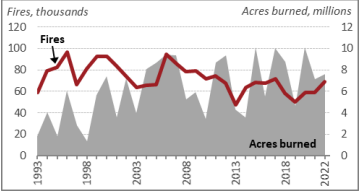

In [66]:
plt_img_base64(docs[0])

In [67]:
# Check retrieval
query = "Tell me about the percentage of residences burned by wildfires in 2022"
docs = retriever_multi_vector.invoke(query, limit=5)

# We get 4 docs
len(docs)

4

In [71]:
print(docs[0])

```table
                      2019       2020      2021       2022

 Structures  Burned    963      17,904     5,972      2,717

 %  Residences         46%       54%        60%        46%
```


### Utilities to separate retrieved elements

We need to bin the retrieved doc(s) into the correct parts of the GPT-4o prompt template.

Here we need to have text, table elements as one set of inputs and image elements as the other set of inputs as both require separate prompts in GPT-4o.

In [77]:
import re
import base64

def looks_like_base64(sb):
    """Check if the string looks like base64"""
    return re.match("^[A-Za-z0-9+/]+[=]{0,2}$", sb) is not None


def is_image_data(b64data):
    """
    Check if the base64 data is an image by looking at the start of the data
    """
    image_signatures = {
        b"\xff\xd8\xff": "jpg",
        b"\x89\x50\x4e\x47\x0d\x0a\x1a\x0a": "png",
        b"\x47\x49\x46\x38": "gif",
        b"\x52\x49\x46\x46": "webp",
    }
    try:
        header = base64.b64decode(b64data)[:8]  # Decode and get the first 8 bytes
        for sig, format in image_signatures.items():
            if header.startswith(sig):
                return True
        return False
    except Exception:
        return False


def split_image_text_types(docs):
    """
    Split base64-encoded images and texts
    """
    b64_images = []
    texts = []
    for doc in docs:
        # Check if the document is of type Document and extract page_content if so
        if isinstance(doc, Document):
            doc = doc.page_content
        if looks_like_base64(doc) and is_image_data(doc):
            b64_images.append(doc)
        else:
            texts.append(doc)
    return {"images": b64_images, "texts": texts}

## Multimodal RAG

### Build End-to-End Multimodal RAG Pipeline

Now let's connect our retriever, prompt instructions and build a multimodal RAG chain

In [78]:
from operator import itemgetter
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
from langchain_core.messages import HumanMessage

def multimodal_prompt_function(data_dict):
    """
    Create a multimodal prompt with both text and image context.

    This function formats the provided context from `data_dict`, which contains
    text, tables, and base64-encoded images. It joins the text (with table) portions
    and prepares the image(s) in a base64-encoded format to be included in a message.

    The formatted text and images (context) along with the user question are used to
    construct a prompt for GPT-4o
    """
    formatted_texts = "\n".join(data_dict["context"]["texts"])
    messages = []

    # Adding image(s) to the messages if present
    if data_dict["context"]["images"]:
        for image in data_dict["context"]["images"]:
            image_message = {
                "type": "image_url",
                "image_url": {"url": f"data:image/jpeg;base64,{image}"},
            }
            messages.append(image_message)

    # Adding the text for analysis
    text_message = {
        "type": "text",
        "text": (
            f"""You are an analyst tasked with understanding detailed information and trends from text documents,
                data tables, and charts and graphs in images.
                You will be given context information below which will be a mix of text, tables, and images usually of charts or graphs.
                Use this information to provide answers related to the user question.
                Do not make up answers, use the provided context documents below and answer the question to the best of your ability.

                User question:
                {data_dict['question']}

                Context documents:
                {formatted_texts}

                Answer:
            """
        ),
    }
    messages.append(text_message)
    return [HumanMessage(content=messages)]


# Create RAG chain
multimodal_rag = (
        {
            "context": itemgetter('context'),
            "question": itemgetter('input'),
        }
            |
        RunnableLambda(multimodal_prompt_function)
            |
        chatgpt
            |
        StrOutputParser()
)

# Pass input query to retriever and get context document elements
retrieve_docs = (itemgetter('input')
                    |
                retriever_multi_vector
                    |
                RunnableLambda(split_image_text_types))

# Below, we chain `.assign` calls. This takes a dict and successively
# adds keys-- "context" and "answer"-- where the value for each key
# is determined by a Runnable (function or chain executing at runtime).
# This helps in also having the retrieved context along with the answer generated by GPT-4o
multimodal_rag_w_sources = (RunnablePassthrough.assign(context=retrieve_docs)
                                               .assign(answer=multimodal_rag)
)

In [90]:
from IPython.display import display, Markdown

def multimodal_rag_qa(query):
    response = multimodal_rag_w_sources.invoke({'input': query})
    print('=='*50)
    print('Answer:')
    display(Markdown(response['answer']))
    print('--'*50)
    print('Sources:')
    text_sources = response['context']['texts']
    img_sources = response['context']['images']
    for text in text_sources[:2]:
        print(text)
        print()
    for img in img_sources[:2]:
        plt_img_base64(img)
        print()
    print('=='*50)

Answer:


Based on the provided data, here are the detailed statistics for the top 5 years with the largest wildfire acres burned:

1. **2015**
   - Acres burned: 10.13 million
   - Number of fires: 68.2 thousand

2. **2020**
   - Acres burned: 10.12 million
   - Number of fires: 59.0 thousand

3. **2017**
   - Acres burned: 10.03 million
   - Number of fires: 71.5 thousand

4. **2006**
   - Acres burned: 9.87 million
   - Number of fires: 96.4 thousand

5. **2007**
   - Acres burned: 9.33 million
   - Number of fires: 67.8 thousand

These years represent the highest acreage burned due to wildfires, with 2015 having the largest area affected.

----------------------------------------------------------------------------------------------------
Sources:
```table
                  2018     2019     2020     2021     2022

 Number   of  Fires  (thousands)

 Federal          12.5      10.9     14.4     14.0     11.7

     FS            5.6      5.3      6.7       6.2     5.9

     DOI           7.0      5.3      7.6       7.6     5.8

     Other         0.1      0.2      <0.1      0.2     0.1

 Nonfederal       45.6      39.6     44.6     45.0     57.2

 Total            58.1     50.5      59.0     59.0    69.0

 Acres  Burned  (millions)

 Federal           4.6      3.1      7.1       5.2     4.0

     FS            2.3      0.6      4.8       4.1     1.9

     DOI           2.3      2.3      2.3       1.0     2.1

     Other        <0.1      <0.1     <0.1     <0.1     <0.1

 Nonfederal        4.1      1.6      3.1       1.9     3.6

 Total             8.8      4.7      10.1     7.1      7.6
```



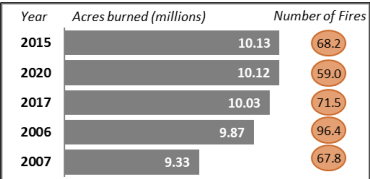

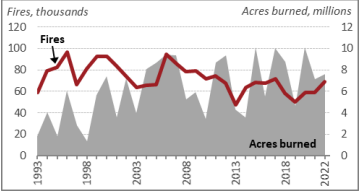

In [91]:
query = "Tell me detailed statistics of the top 5 years with largest wildfire acres burned"
multimodal_rag_qa(query)

Answer:


The trend in annual wildfires and acres burned shows some key patterns:

1. **Number of Fires:**
   - The number of fires has fluctuated over the years. For example, in 2015, there were 68.2 thousand fires, while in 2020, there were 59.0 thousand fires.
   - From 2018 to 2022, the total number of fires increased from 58.1 thousand to 69.0 thousand.

2. **Acres Burned:**
   - The acres burned have varied significantly. In 2015, 10.13 million acres were burned, and in 2020, it was 10.12 million acres.
   - From 2018 to 2022, the total acres burned ranged from 4.7 million in 2019 to 10.1 million in 2020.

3. **Regional Differences:**
   - The West Federal region consistently had a significant portion of the acres burned, especially in 2020.
   - The East regions (both Federal and Nonfederal) generally had fewer acres burned compared to the West.

Overall, while the number of fires has shown some variability, the acres burned have seen more dramatic fluctuations, with certain years experiencing significantly higher burn areas.

----------------------------------------------------------------------------------------------------
Sources:
```table
                  2018     2019     2020     2021     2022

 Number   of  Fires  (thousands)

 Federal          12.5      10.9     14.4     14.0     11.7

     FS            5.6      5.3      6.7       6.2     5.9

     DOI           7.0      5.3      7.6       7.6     5.8

     Other         0.1      0.2      <0.1      0.2     0.1

 Nonfederal       45.6      39.6     44.6     45.0     57.2

 Total            58.1     50.5      59.0     59.0    69.0

 Acres  Burned  (millions)

 Federal           4.6      3.1      7.1       5.2     4.0

     FS            2.3      0.6      4.8       4.1     1.9

     DOI           2.3      2.3      2.3       1.0     2.1

     Other        <0.1      <0.1     <0.1     <0.1     <0.1

 Nonfederal        4.1      1.6      3.1       1.9     3.6

 Total             8.8      4.7      10.1     7.1      7.6
```



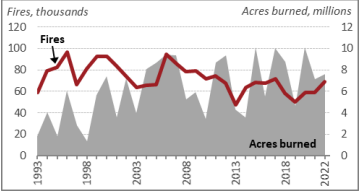

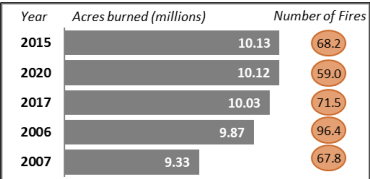

In [92]:
# Run RAG chain
query = "Tell me about the annual wildfires trend with acres burned"
multimodal_rag_qa(query)